In [1]:
import sys
import os
sys.path.append('../')
from source.interference_reject import InterferenceReject
from source.utils import compute_kspace_weights
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
from source.combine import CoilCombo
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [18]:
file_name = "/Users/had-mr/github/data_interference/nr032.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
n_channels = metadata['console']['adc']['number_channels']
n_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(n_channels_signal)
select_channels_noise = np.arange(n_channels_signal, n_channels)
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [19]:
data_scan = data['scan']
n_lines, n_channels, n_readout = data_scan.shape
data_prescan = data['noise']
# Static method: compute coefficients from a noise-only prescan
interf_rej = InterferenceReject(channels_signal=select_channels_signal, channels_noise=select_channels_noise)
data_cor_static = interf_rej.apply(data_signal=data_scan, data_noise=data_prescan)

# Dynamic method with k-space weighting: compute coefficients on the fly, in data bins
# Dynamic correction with k-space weighting
lines_per_bin = 100
num_bins = int(np.ceil(n_lines / lines_per_bin))
lines_per_bin = int(np.round(n_lines / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [n_lines - 1]))
interf_rej = InterferenceReject(channels_signal=select_channels_signal, channels_noise=select_channels_noise)
data_cor_dyn = np.zeros([n_lines, n_channels_signal, n_readout], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_bin = data_scan[sel_bin, :, :]
    k_weights = compute_kspace_weights(
        k_coords=k_2d[sel_bin, :], 
        n_readout=n_readout, 
        n_channels=n_channels)
    data_cor_dyn[sel_bin, :, :] = interf_rej.apply(data_signal=data_bin, data_noise=k_weights * data_bin)


## Plot k-space

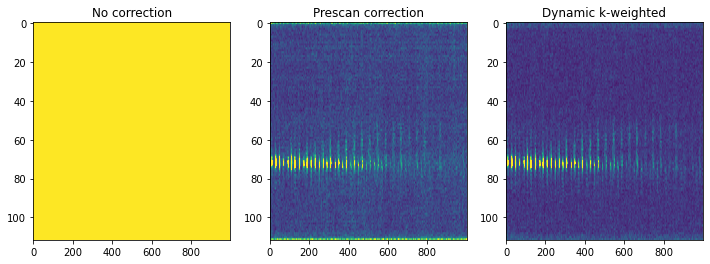

In [20]:
ch = 3
n_lines = 1000
max_k = np.max(np.abs(data_cor_static)) / 20
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,4))
ax[0].set_title("No correction")
ax[0].imshow(np.squeeze(np.abs(data['scan'][:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k)
ax[1].set_title("Prescan correction")
ax[1].imshow(np.squeeze(np.abs(data_cor_static[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k)
ax[2].set_title("Dynamic k-weighted")
ax[2].imshow(np.squeeze(np.abs(data_cor_dyn[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k)
# fig.savefig("methods_rejection_kspace.tif", dpi=600, format="tiff")
fig.savefig("methods_rejection_kspace.png")

## Fourier reconstruction

In [21]:
# Apply readout FT
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
spec_cor_static = np.fft.fftshift(np.fft.fft(data_cor_static, axis=-1), axes=-1)
spec_cor_dyn = np.fft.fftshift(np.fft.fft(data_cor_dyn, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=n_channels_signal)
dims_4d = np.concatenate((matrix_size, [n_channels_signal]))
im_coils_nocor = np.zeros(dims_4d, dtype=np.complex64)
im_coils_cor_static = np.zeros(dims_4d, dtype=np.complex64)
im_coils_cor_dyn = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(dims_4d[0]):
    tmp = encode_op.adjoint(spec_scan[:, :8, _f])
    im_coils_nocor[_f, :, :, :] = encode_op.adjoint(spec_scan[:, :8, _f])
    im_coils_cor_static[_f, :, :, :] = encode_op.adjoint(spec_cor_static[:, :, _f])
    im_coils_cor_dyn[_f, :, :, :] = encode_op.adjoint(spec_cor_dyn[:, :, _f])

## Coil Combine

In [22]:
# Combine data - sum of square
comb_complex = CoilCombo(matrix_size=matrix_size, size_patch=[6, 6, 3])
im_nocor = comb_complex.forward(im_coils_nocor, data_noise=None, flag_prewhite=False, mode='SoS')
im_cor_static = comb_complex.forward(im_coils_cor_static, data_noise=None, flag_prewhite=False, mode='SoS')
im_cor_dyn = comb_complex.forward(im_coils_cor_dyn, data_noise=None, flag_prewhite=False, mode='SoS')

# Combine data - adaptive
k_weights = compute_kspace_weights(k_coords=k_2d, n_readout=n_readout, n_channels=n_channels_signal, threshold=0.8)
data_weighted = data_cor_dyn * k_weights
im_cor_dyn_adapt = comb_complex.forward(im_coils_cor_dyn, data_noise=data_weighted, flag_prewhite=False, mode='adaptive')


Interpolate dimension 0 from 112 to 114
Interpolate dimension 1 from 136 to 138


## Image figures

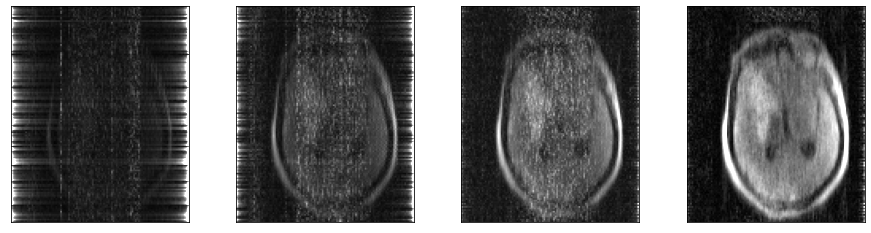

In [25]:
scaling = 5
slc = 25
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax[0].imshow(np.abs(im_nocor[:, :, slc]).T, cmap='gray', aspect='equal', vmin=0, vmax=scaling * np.mean(im_nocor))
ax[1].imshow(np.abs(im_cor_static[:, :, slc]).T, cmap='gray', aspect='equal', vmin=0, vmax=scaling * np.mean(im_cor_static))
ax[2].imshow(np.abs(im_cor_dyn[:, :, slc]).T, cmap='gray', aspect='equal', vmin=0, vmax=scaling * np.mean(im_cor_dyn))
ax[3].imshow(np.abs(im_cor_dyn_adapt[:, :, slc]).T, cmap='gray', aspect='equal', vmin=0, vmax=scaling * np.mean(np.abs(im_cor_dyn_adapt)))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")
dir_data, file_data = os.path.split(file_name)
dir_fig = os.path.join(dir_data, "figures_image")
if not os.path.isdir(dir_fig):
    os.mkdir(dir_fig)
file_fig = os.path.splitext(file_data)[0] + ".png"
fig.savefig(os.path.join(dir_fig, file_fig))